In [1]:
try:
  # %tensorflow_version only exists in Colab.
  %tensorflow_version 2.x
except Exception:
  pass


In [2]:
import tensorflow as tf
print(tf.__version__)


2.1.0


The next code block will set up the time series with seasonality, trend and a bit of noise. 

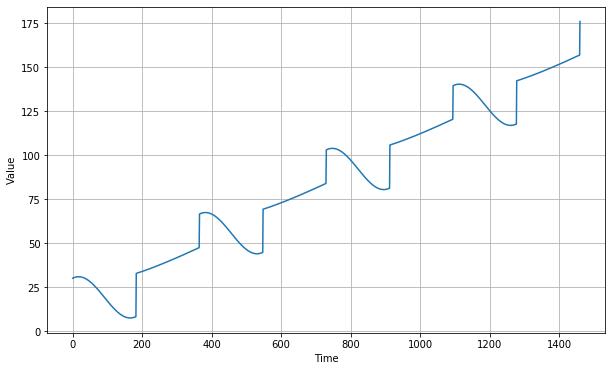

In [74]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras

def plot_series(time, series, format="-", start=0, end=None):
    plt.plot(time[start:end], series[start:end], format)
    plt.xlabel("Time")
    plt.ylabel("Value")
    plt.grid(True)

def trend(time, slope=0):
    return slope * time

def seasonal_pattern(season_time):
    """Just an arbitrary pattern, you can change it if you wish"""
    return np.where(season_time < 0.5,
                    np.cos(season_time * 2 * np.pi),
                    1 / np.exp(3 * season_time))

def seasonality(time, period, amplitude=1, phase=0):
    """Repeats the same pattern at each period"""
    season_time = ((time + phase) % period) / period
    return amplitude * seasonal_pattern(season_time)

def noise(time, noise_level=1, seed=None):
    rnd = np.random.RandomState(seed)
    return rnd.randn(len(time)) * noise_level

time = np.arange(4 * 365 + 1, dtype="int")
baseline = 10
series = trend(time, 0.1)  
baseline = 10
amplitude = 20
slope = 0.1
noise_level = 0

# Create the series
series = baseline + trend(time, slope) + seasonality(time, period=365, amplitude=amplitude)
# Update with noise
series += noise(time, noise_level, seed=42)

plt.figure(figsize=(10, 6))
plot_series(time, series)
plt.show()

Now that we have the time series, let's split it so we can start forecasting

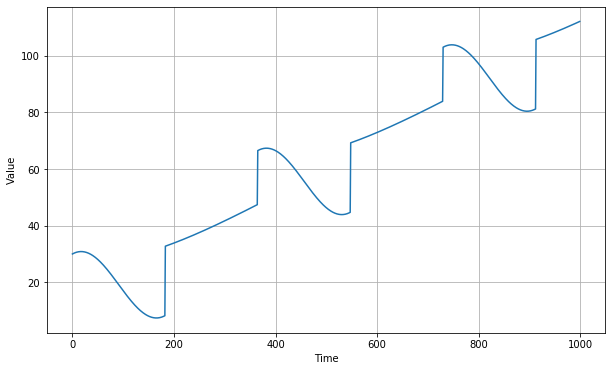

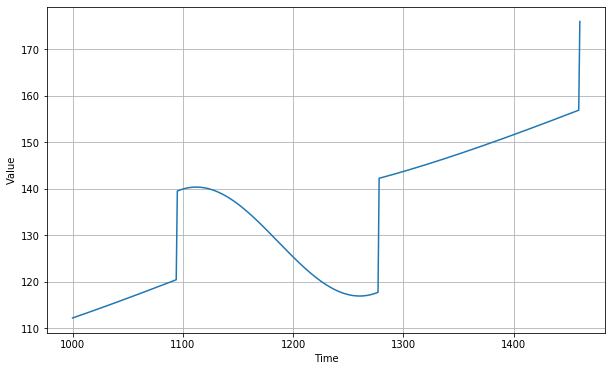

In [75]:
split_time = 1000
time_train = time[:split_time]
x_train = series[:split_time]
time_valid = time[split_time:]
x_valid = series[split_time:]
plt.figure(figsize=(10, 6))
plot_series(time_train, x_train)
plt.show()

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plt.show()

# Naive Forecast (use to get a baseline)

In [76]:
naive_forecast = series[split_time - 1:-1] # guess in 1 behind actual

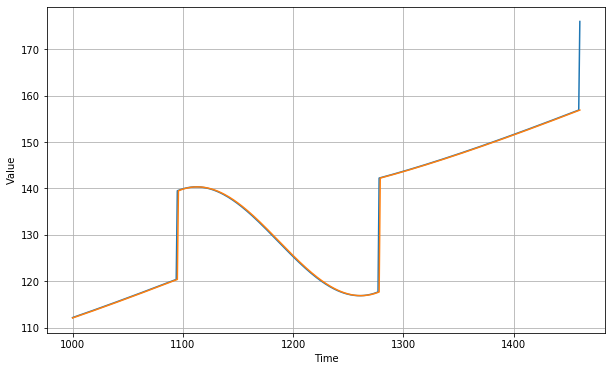

In [77]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, naive_forecast)

Let's zoom in on the start of the validation period:

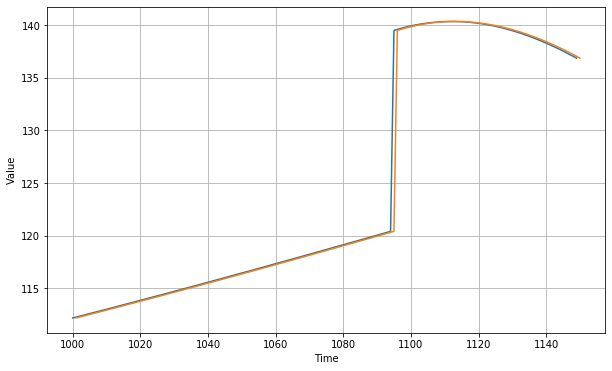

In [78]:
plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid, start=0, end=150)
plot_series(time_valid, naive_forecast, start=1, end=151)

You can see that the naive forecast lags 1 step behind the time series.

Now let's compute the mean squared error and the mean absolute error between the forecasts and the predictions in the validation period:

In [79]:
print(keras.metrics.mean_squared_error(x_valid, naive_forecast).numpy())
print(keras.metrics.mean_absolute_error(x_valid, naive_forecast).numpy())

2.902964786170536
0.24036045032057116


That's our baseline, now let's try a moving average:

In [80]:
def moving_average_forecast(series, window_size):
  """Forecasts the mean of the last few values.
     If window_size=1, then this is equivalent to naive forecast"""
  forecast = []
  for time in range(len(series) - window_size):             #from 0 to end minus window size
    forecast.append(series[time:time + window_size].mean()) #At each time interval get the mean from time to time+window
  return np.array(forecast)

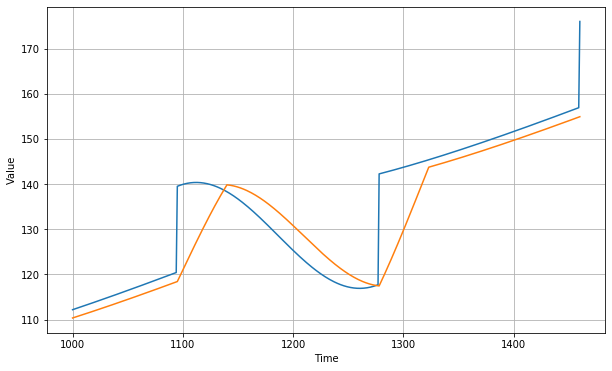

In [81]:
moving_avg = moving_average_forecast(series, 45)[split_time - 45:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, moving_avg)

In [82]:
print(keras.metrics.mean_squared_error(x_valid, moving_avg).numpy())
print(keras.metrics.mean_absolute_error(x_valid, moving_avg).numpy())

45.78793313449428
4.516546604125934


That's worse than naive forecast! The moving average does not anticipate trend or seasonality, so let's try to remove them by using differencing. Since the seasonality period is 365 days, we will subtract the value at time *t* – 365 from the value at time *t*.

[33.86474869 33.93311381 34.00173789 34.07061879 34.13975441 34.20914268
 34.27878152 34.34866888 34.41880273 34.48918104 34.55980183 34.63066309
 34.70176287 34.77309922 34.84467019 34.91647387 34.98850834 35.06077173
 35.13326216 35.20597776 35.27891671 35.35207716 35.4254573  35.49905534
 35.5728695  35.646898   35.72113909 35.79559102 35.87025209 35.94512056
 36.02019475 36.09547296 36.17095354 36.24663482 36.32251516 36.39859293
 36.47486652 36.55133432 36.62799475 36.70484621 36.78188717 36.85911605
 36.93653132 37.01413146 37.09191496 37.16988031 37.24802602 37.32635062
 37.40485265 37.48353065 37.56238317 37.64140881 37.72060612 37.79997372
 37.8795102  37.95921419 38.03908431 38.1191192  38.19931752 38.27967792
 38.36019908 38.44087969 38.52171843 38.60271402 38.68386518 38.76517061
 38.84662907 38.92823931 39.01000007 39.09191013 39.17396827 39.25617326
 39.33852392 39.42101905 39.50365746 39.58643799 39.66935947 39.75242074
 39.83562066 39.9189581  40.00243194 40.08604104 40

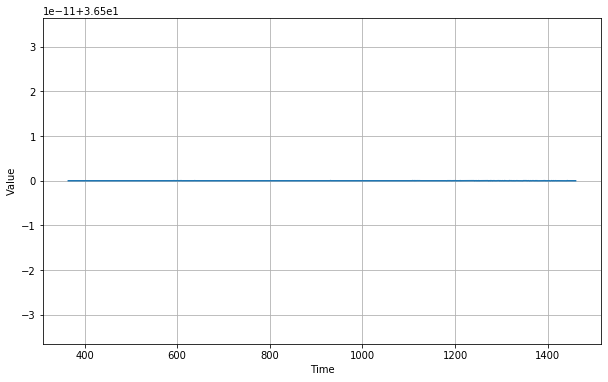

In [83]:
diff_series = (series[365:] - series[:-365])
diff_time = time[365:]

print(series[200:400])
print("-------------")
print(series[0:200])
print("-------------")
print(diff_series)

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series)
# plot_series(diff_time, series[200:400])
plt.show()

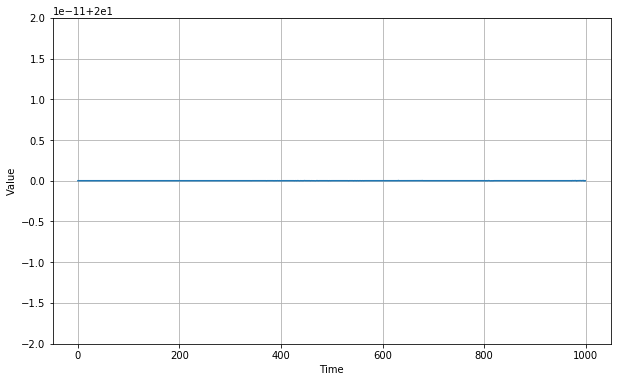

In [72]:
diff_series = (series[200:1200] - series[0:1000])
diff_time = time[0:1000]

plt.figure(figsize=(10, 6))
plot_series(diff_time, diff_series)
#plot_series(diff_time, series[0:200])
plt.show()

Great, the trend and seasonality seem to be gone, so now we can use the moving average:

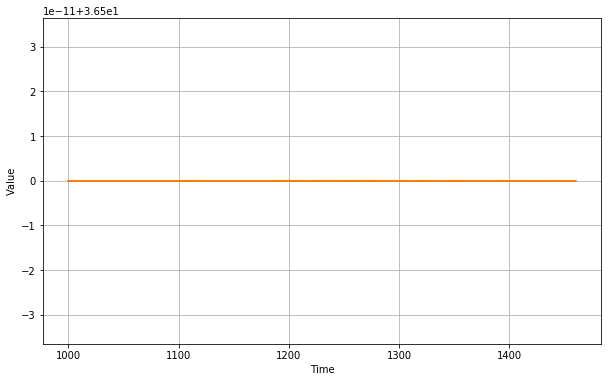

In [84]:
diff_moving_avg = moving_average_forecast(diff_series, 50)[split_time - 365 - 50:]

plt.figure(figsize=(10, 6))
plot_series(time_valid, diff_series[split_time - 365:])
plot_series(time_valid, diff_moving_avg)
plt.show()

Now let's bring back the trend and seasonality by adding the past values from t – 365:

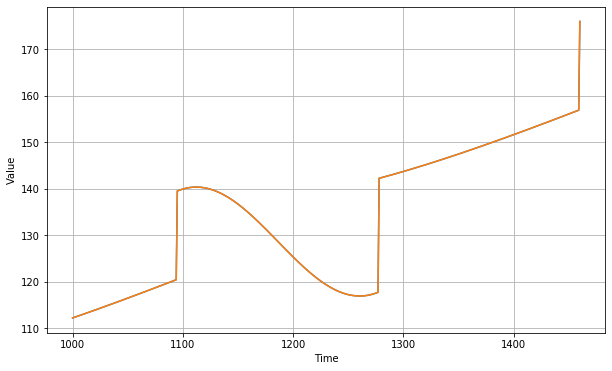

In [85]:
diff_moving_avg_plus_past = series[split_time - 365:-365] + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_past)
plt.show()

In [86]:

print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_past).numpy())

1.690934473108883e-28
6.658448196276861e-15


Better than naive forecast, good. However the forecasts look a bit too random, because we're just adding past values, which were noisy. Let's use a moving averaging on past values to remove some of the noise:

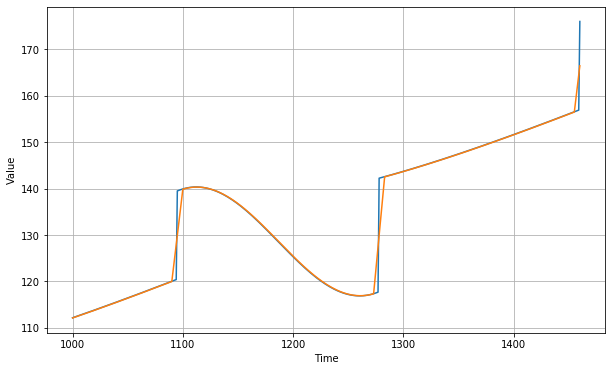

In [87]:
diff_moving_avg_plus_smooth_past = moving_average_forecast(series[split_time - 370:-360], 10) + diff_moving_avg

plt.figure(figsize=(10, 6))
plot_series(time_valid, x_valid)
plot_series(time_valid, diff_moving_avg_plus_smooth_past)
plt.show()

In [0]:
print(keras.metrics.mean_squared_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())
print(keras.metrics.mean_absolute_error(x_valid, diff_moving_avg_plus_smooth_past).numpy())